<a href="https://colab.research.google.com/github/Sentinel-FYP/colab_notebooks/blob/main/sentinel_model_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Data

### Install Dependencies

In [ ]:
# @title
!pip install tf-models-official
!sudo apt install -y ffmpeg
!pip install -q mediapy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.9 MB/s eta 0:00:00
 

### Import Packages

In [ ]:
import pathlib
import random

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import PIL
import matplotlib as mpl
import tqdm


import mediapy as media
import tensorflow as tf

# Some modules to display an animation using imageio.
import imageio
from IPython import display

# Import the MoViNet model from TensorFlow Models (tf-models-official) for the MoViNet model
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model

### Set Constants

In [ ]:
num_classes = 2
batch_size = 1
resolution = 172
num_frames = 100
frame_step = 10
epochs = 5
model_id = 'a0'
export_model = True
load_saved_model=True
evaluate = False
export_model_name = 'a0_stream_4.0'
frame_shape = (num_frames, resolution, resolution, 3)
input_shape = (batch_size, num_frames, resolution, resolution, 3)

### Create Directory Structure

In [ ]:
paths = {}
paths['root'] = pathlib.Path('/content/drive/MyDrive/ucf_dataset')
assert paths['root'].exists() == True
paths['models'] = (paths['root'] / 'models' / model_id)
paths['tflite'] = (paths['root'] / 'tf_lite_models' / model_id)
paths['checkpoints_dir'] = (paths['root'] / 'checkpoints' / model_id / export_model_name)
paths['checkpoints_file'] = (paths['checkpoints_dir'] / 'cp.ckpt')

In [ ]:
for p in paths.values():
  assert p.exists() == True

In [ ]:
annotations = pd.read_csv(paths['root'] / 'frame_annotations.csv')
annotations = annotations.set_index('file_name')
annotations['binary_class'] = annotations['is_annomaly'].map({1.0 : 'Anomaly', 0.0 : "Normal"})

### Define Helper Functions Loading Video

In [ ]:
# @title
def get_class(fname):
  """ Retrieve the name of the class given a filename/file_path.

    Args:
      fname: Name of the file in the UCF Crime dataset.
    Returns:
      Class that the file belongs to.
  """
  fname = fname.split('/')[-1]
  class_name = fname.split('_')[0]
  #remove numbers
  class_name = ''.join(char for char in class_name if not char.isnumeric())
  if class_name == "Normal":
    return "Normal"
  else:
    return "Anomaly"

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame


def load_video(video_path, output_size=(resolution, resolution), n_frames=100, frame_step=frame_step):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)
  need_length = 1 + (n_frames - 1) * frame_step
  start = 0
  if need_length > video_length:
    end = video_length
  else:
    end = need_length

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  frame_count = start + 1;
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
      frame_count += 1;
    if ret and frame_count < end and frame is not None:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      break
  src.release()
  # result.append(np.zeros_like(result[0]))
  result = np.array(result)[..., [2, 1, 0]]

  return result


# @title
def get_video_annotations(video_path, annotations_df=annotations):
  video_name = str(video_path).split("/")[-1]
  return annotations_df.loc[video_name].to_dict()



def frames_from_video_file(video_path, n_frames, output_size, frame_step):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  video_annotations = get_video_annotations(video_path)
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)
  need_length = 1 + (n_frames - 1) * frame_step
  if video_annotations['anomaly_1_start'] == -1:
    if need_length > video_length:
      start = 0
      end = video_length
    else:
      max_start = video_length - need_length
      start = random.randint(0, max_start + 1)
      end = start + need_length
  else:
    start = video_annotations['anomaly_1_start']
    end = video_annotations['anomaly_1_end']
  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  frame_count = start + 1;
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
      frame_count += 1;
    if ret and frame_count < end and frame is not None:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      break
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

### Create Dataset Paths

In [ ]:
dataset_paths = {}
dataset_directory = pathlib.Path('/content/drive/MyDrive/ucf_extracted')
dataset_paths['train'] = dataset_directory / 'train'
dataset_paths['test'] = dataset_directory / 'test'

In [ ]:
for p in dataset_paths.values():
  assert p.exists() == True

### Helper functions for model output

In [ ]:
# @title
# Get top_k labels and probabilities
def get_top_k(probs, k=5, label_map=['Anomaly', 'Normal']):
  """Outputs the top k model labels and probabilities on the given video.

  Args:
    probs: probability tensor of shape (num_frames, num_classes) that represents
      the probability of each class on each frame.
    k: the number of top predictions to select.
    label_map: a list of labels to map logit indices to label strings.

  Returns:
    a tuple of the top-k labels and probabilities.
  """
  # Sort predictions to find top_k
  top_predictions = tf.argsort(probs, axis=-1, direction='DESCENDING')[:k]
  # collect the labels of top_k predictions
  top_labels = tf.gather(label_map, top_predictions, axis=-1)
  # decode lablels
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]
  # top_k probabilities of the predictions
  top_probs = tf.gather(probs, top_predictions, axis=-1).numpy()
  return tuple(zip(top_labels, top_probs))

In [ ]:
# @title
# Get top_k labels and probabilities predicted using MoViNets streaming model
def get_top_k_streaming_labels(probs, k=5, label_map=['Anomaly', 'Normal']):
  """Returns the top-k labels over an entire video sequence.

  Args:
    probs: probability tensor of shape (num_frames, num_classes) that represents
      the probability of each class on each frame.
    k: the number of top predictions to select.
    label_map: a list of labels to map logit indices to label strings.

  Returns:
    a tuple of the top-k probabilities, labels, and logit indices
  """
  top_categories_last = tf.argsort(probs, -1, 'DESCENDING')[-1, :1]
  # Sort predictions to find top_k
  categories = tf.argsort(probs, -1, 'DESCENDING')[:, :k]
  categories = tf.reshape(categories, [-1])

  counts = sorted([
      (i.numpy(), tf.reduce_sum(tf.cast(categories == i, tf.int32)).numpy())
      for i in tf.unique(categories)[0]
  ], key=lambda x: x[1], reverse=True)

  top_probs_idx = tf.constant([i for i, _ in counts[:k]])
  top_probs_idx = tf.concat([top_categories_last, top_probs_idx], 0)
  # find unique indices of categories
  top_probs_idx = tf.unique(top_probs_idx)[0][:k+1]
  # top_k probabilities of the predictions
  top_probs = tf.gather(probs, top_probs_idx, axis=-1)
  top_probs = tf.transpose(top_probs, perm=(1, 0))
  # collect the labels of top_k predictions
  top_labels = tf.gather(label_map, top_probs_idx, axis=0)
  # decode the top_k labels
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]

  return top_probs, top_labels, top_probs_idx

# Plot top_k predictions at a given time step
def plot_streaming_top_preds_at_step(
    top_probs,
    top_labels,
    step=None,
    image=None,
    legend_loc='lower left',
    duration_seconds=10,
    figure_height=500,
    playhead_scale=0.8,
    grid_alpha=0.3):
  """Generates a plot of the top video model predictions at a given time step.

  Args:
    top_probs: a tensor of shape (k, num_frames) representing the top-k
      probabilities over all frames.
    top_labels: a list of length k that represents the top-k label strings.
    step: the current time step in the range [0, num_frames].
    image: the image frame to display at the current time step.
    legend_loc: the placement location of the legend.
    duration_seconds: the total duration of the video.
    figure_height: the output figure height.
    playhead_scale: scale value for the playhead.
    grid_alpha: alpha value for the gridlines.

  Returns:
    A tuple of the output numpy image, figure, and axes.
  """
  # find number of top_k labels and frames in the video
  num_labels, num_frames = top_probs.shape
  if step is None:
    step = num_frames
  # Visualize frames and top_k probabilities of streaming video
  fig = plt.figure(figsize=(6.5, 7), dpi=300)
  gs = mpl.gridspec.GridSpec(8, 1)
  ax2 = plt.subplot(gs[:-3, :])
  ax = plt.subplot(gs[-3:, :])
  # display the frame
  if image is not None:
    ax2.imshow(image, interpolation='nearest')
    ax2.axis('off')
  # x-axis (frame number)
  preview_line_x = tf.linspace(0., duration_seconds, num_frames)
  # y-axis (top_k probabilities)
  preview_line_y = top_probs

  line_x = preview_line_x[:step+1]
  line_y = preview_line_y[:, :step+1]

  for i in range(num_labels):
    ax.plot(preview_line_x, preview_line_y[i], label=None, linewidth='1.5',
            linestyle=':', color='gray')
    ax.plot(line_x, line_y[i], label=top_labels[i], linewidth='2.0')


  ax.grid(which='major', linestyle=':', linewidth='1.0', alpha=grid_alpha)
  ax.grid(which='minor', linestyle=':', linewidth='0.5', alpha=grid_alpha)

  min_height = tf.reduce_min(top_probs) * playhead_scale
  max_height = tf.reduce_max(top_probs)
  ax.vlines(preview_line_x[step], min_height, max_height, colors='red')
  ax.scatter(preview_line_x[step], max_height, color='red')

  ax.legend(loc=legend_loc)

  plt.xlim(0, duration_seconds)
  plt.ylabel('Probability')
  plt.xlabel('Time (s)')

  fig.tight_layout()
  fig.canvas.draw()

  data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
  plt.close()

  figure_width = int(figure_height * data.shape[1] / data.shape[0])
  image = PIL.Image.fromarray(data).resize([figure_width, figure_height])
  image = np.array(image)

  return image

# Plotting top_k predictions from MoViNets streaming model
def plot_streaming_top_preds(
    probs,
    video,
    top_k=5,
    video_fps=25.,
    figure_height=500,
    use_progbar=True):
  """Generates a video plot of the top video model predictions.

  Args:
    probs: probability tensor of shape (num_frames, num_classes) that represents
      the probability of each class on each frame.
    video: the video to display in the plot.
    top_k: the number of top predictions to select.
    video_fps: the input video fps.
    figure_fps: the output video fps.
    figure_height: the height of the output video.
    use_progbar: display a progress bar.

  Returns:
    A numpy array representing the output video.
  """
  # select number of frames per second
  video_fps = 8.
  # select height of the image
  figure_height = 500
  # number of time steps of the given video
  steps = video.shape[0]
  # estimate duration of the video (in seconds)
  duration = steps / video_fps
  # estiamte top_k probabilities and corresponding labels
  top_probs, top_labels, _ = get_top_k_streaming_labels(probs, k=top_k)

  images = []
  step_generator = tqdm.trange(steps) if use_progbar else range(steps)
  for i in step_generator:
    image = plot_streaming_top_preds_at_step(
        top_probs=top_probs,
        top_labels=top_labels,
        step=i,
        image=video[i],
        duration_seconds=duration,
        figure_height=figure_height,
    )
    images.append(image)

  return np.array(images)

## Load Stream Model

In [ ]:
if not load_saved_model:
  model_id = 'a0'
  use_positional_encoding = model_id in {'a3', 'a4', 'a5'}

  # Create backbone and model.
  backbone = movinet.Movinet(
      model_id=model_id,
      causal=True,
      conv_type='2plus1d',
      se_type='2plus3d',
      activation='hard_swish',
      gating_activation='hard_sigmoid',
      use_positional_encoding=use_positional_encoding,
      use_external_states=True,
  )

  model = movinet_model.MovinetClassifier(
      backbone,
      num_classes=num_classes,
      output_states=True)


  # Load weights from the checkpoint to the rebuilt model
  model.load_weights(tf.train.latest_checkpoint(paths['checkpoints_dir']))

In [ ]:
if load_saved_model:
  model = tf.saved_model.load(paths['models'] / export_model_name)

## Testing

### Get Correctly Predicted Files

In [ ]:
results_dir = paths['root']/'results' / export_model_name
results = pd.read_csv(results_dir/'train.csv')
results = results[results['actual'] == results['predicted']]
print(f'Total Files: {len(results)}')

Total Files: 695


In [ ]:
normal_files = results[results['class'] == 'Normal']['file'].tolist()
print(f'Total Normal Files: {len(normal_files)}')

Total Normal Files: 382


In [ ]:
anomaly_files = results[results['class'] == 'Anomaly']['file'].tolist()
print(f'Total Anomaly Files: {len(anomaly_files)}')

Total Anomaly Files: 313


### Load Random Video

In [ ]:
def load_random_video(files):
  random_id = random.randint(0, len(files)-1)
  video_path = files[random_id]
  print(f'Loading: {video_path}')
  #video = load_video(video_path, n_frames=600, frame_step=frame_step)
  video = frames_from_video_file(video_path, n_frames=100, output_size=(resolution, resolution), frame_step=5)
  return video

In [ ]:
normal_video = load_random_video(normal_files)
print(normal_video.shape)
media.show_video(normal_video, fps=25)

Loading: /content/drive/MyDrive/ucf_extracted/train/Normal/Normal_Videos102_x264.mp4
(99, 172, 172, 3)


In [ ]:
anomaly_video = load_random_video(anomaly_files)
print(anomaly_video.shape)
media.show_video(anomaly_video, fps=25)

Loading: /content/drive/MyDrive/ucf_extracted/train/Anomaly/Explosion026_x264.mp4
(79, 172, 172, 3)


### Test Stream Model

In [ ]:
init_states = model.init_states([1, 1, resolution, resolution, 3])

In [ ]:
# warm up the model
%%time
_, __ = model({**init_states, 'image':  tf.ones([1, 1, 172, 172, 3])})

CPU times: user 3.92 s, sys: 72.7 ms, total: 3.99 s
Wall time: 3.95 s


In [ ]:
%matplotlib inline
def predict(video, title):
  inputs = tf.expand_dims(video, axis=0)
  frames = tf.split(inputs, inputs.shape[1], axis=1)
  all_logits = []
  states = init_states.copy()
  for frame in tqdm.tqdm(frames):
    logits, states = model({**states, 'image': frame})
    all_logits.append(logits)

  logits = tf.concat(all_logits, 0)
  probabilities = tf.nn.softmax(logits, axis=-1)
  for label, p in get_top_k(probabilities[-1]):
    print(f'{label:20s}: {p:.3f}')

  plt.plot(probabilities[:,0], label='Anomaly')
  plt.plot(probabilities[:,1], label='Normal')
  plt.xlabel("Frames")
  plt.ylabel("Class Probability")
  plt.title(title)
  plt.legend()


100%|██████████| 99/99 [00:04<00:00, 20.34it/s]


Normal              : 1.000
Anomaly             : 0.000
CPU times: user 4.1 s, sys: 202 ms, total: 4.3 s
Wall time: 5.09 s


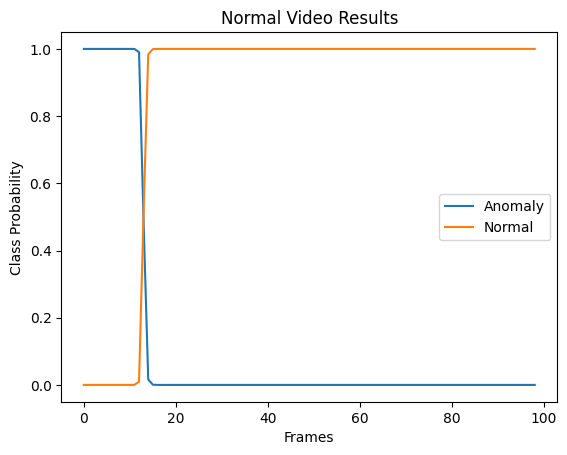

In [ ]:
%%time
predict(normal_video, "Normal Video Results")

100%|██████████| 79/79 [00:03<00:00, 21.97it/s]


Anomaly             : 0.610
Normal              : 0.390
CPU times: user 3.48 s, sys: 169 ms, total: 3.65 s
Wall time: 3.81 s


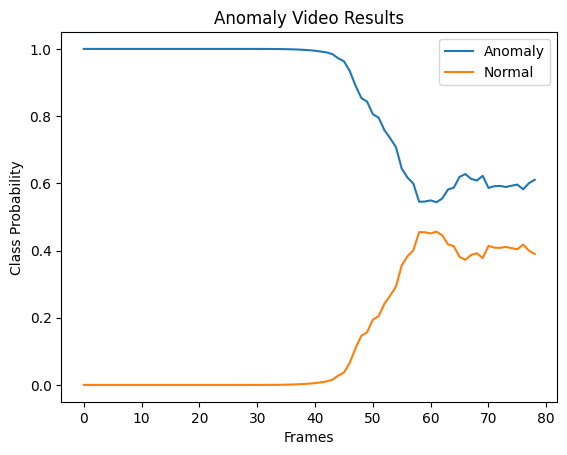

In [ ]:
%%time
predict(anomaly_video, "Anomaly Video Results")

In [ ]:
# plot_video = plot_streaming_top_preds(probabilities, video, video_fps=8.)

In [ ]:
# media.show_video(plot_video, fps=8)

In [ ]:
#%%time
#non_streaming_logits, _ = model({**init_states, 'image': inputs})
#non_streaming_probs = tf.nn.softmax(non_streaming_logits)

In [ ]:
#for label, p in get_top_k(non_streaming_probs[-1]):
#  print(f'{label:20s}: {p:.3f}')